In [35]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stat
from shapely.geometry import Point, LineString
from scipy import optimize
from PIL import Image
import requests
from io import BytesIO
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf
#import shapefile as shp
#from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import os
from networkx.algorithms import community
from sklearn.mixture import GaussianMixture 
import operator
import re

Populating the interactive namespace from numpy and matplotlib


/Users/hemingyi/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['matrix', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [36]:
TransportationDataPath = '/Users/hemingyi/Documents/capstone/transportation/'
SpatialDataPath = '/Users/hemingyi/Documents/capstone/spatial/'
EventDataPath = '/Users/hemingyi/Documents/capstone/event data/new/'
RecordWritingPath = '/Users/hemingyi/Documents/capstone/'

In [37]:
def aggregateByBorough(city,ZoneDict):
    print('aggregateByBorough')
    data = pd.read_csv(TransportationDataPath+city+'EdgeDatewiseAggregated.csv')
#     print(data.columns)
    if 'Date' in data.columns:
        data['date'] = pd.to_datetime(data.Date)
    elif 'date' in data.columns:
        data['date'] = pd.to_datetime(data.date)
    else:
        print(data.columns)
#     print('Days: ',len(set(data.date)))
    aggregatedData = pd.read_csv(TransportationDataPath+city+'EdgeYearwiseAggregated.csv')
#     print('aggeregated shape: ',aggregatedData.shape)
#     print('Avg Edge: ',sum(aggregatedData.amount)/len(aggregatedData))
    partition = ZoneDict
#     print(partition)
    data['start_community'] = data['start_id'].apply(lambda x: partition[str(x)])
    data['end_community'] = data['end_id'].apply(lambda x: partition[str(x)])

    communityData = data[['start_community','end_community','date','amount']]
    communityData = communityData.groupby(['start_community','end_community','date']).sum().reset_index()
    communityData.columns = ['start_id', 'end_id', 'date', 'amount']
#     print('Community Aggregated Shape: ',communityData.shape)

    return communityData

In [38]:
def getTimeSeries(df):
    print('getTimeSeries')
    table = pd.pivot_table(df, values='amount', index=['date'],
                    columns=['start_id','end_id'], aggfunc=np.sum, fill_value=0)
    return table

In [39]:
def anomalyDetection(y,pval = 0.2,iterN=20):
    print('anomalyDetection')
    #index of regular (non-outlier points)
    #rind=y[:,0]>-10 
    rind = np.array(range(y.shape[0]))
    
    #clustering model
    gm=GaussianMixture(n_components=6,n_init=100,max_iter=1000,random_state=0) 
    for i in range(iterN): #iterate
#         print('Iteration {}'.format(i+1))  
        clustering=gm.fit(y[rind,:]) #fit EM clustering model excluding outliers
        l=clustering.score_samples(y) #estimate likelihood for each point
        Lthres=sorted(l)[int(len(l)*pval)] #anomaly threshold
        rind0=0+rind
        rind=l>Lthres #non-anomalous points
        if all(rind==rind0):
#             print('Convergence in {} iterations'.format(i+1))
            break
    return l < Lthres

In [40]:
# import events data
def getEvents(EventDataPath,city):
    events_data =EventDataPath+city+'Events.csv'
    df_events = pd.read_csv(events_data, encoding = "ISO-8859-1", parse_dates=['Date'], infer_datetime_format=True)

    # dataframe for events
    df_finalEvents =  df_events[['Date', 'Type']]

    # list events666
    
    lis_event = df_finalEvents['Type'].unique()
    lis_event = list(lis_event)
    return (lis_event,df_finalEvents)

# Taipei

In [63]:
f = open(RecordWritingPath+'F1ScoreSpatial.txt', 'w+')
f.write('Spatial Aggregation Approach\n')
city = "Taipei"
f.write(city+'\n')
data = pd.read_csv(TransportationDataPath+city+'EdgeDatewiseAggregated.csv')
data['startLine'] = data['start_id'].apply(lambda x: re.split('(\d+)',x)[0])
data['endLine'] = data['end_id'].apply(lambda x: re.split('(\d+)',x)[0])
data = data.groupby(['startLine','endLine','date']).sum().reset_index()
data.columns = ['start_id', 'end_id', 'date', 'amount']

lis_event,df_finalEvents = getEvents(EventDataPath,city)

dataTs = getTimeSeries(data)
matrix = dataTs.values
matrix = np.log(matrix+1)
date = dataTs.index.to_frame().rename(columns={'date':'Date'})
for thres in range(1,10, 1):
    th = thres/10
    print("Threshhold: ",th)
    outliers = anomalyDetection(matrix,pval = th)
    EventsDF = df_finalEvents['Date'].drop_duplicates().to_frame()
    EventsDF['Anomaly'] = True
    date['Date'] = date['Date'].astype('str')
    EventsDF['Date'] = EventsDF['Date'].astype('str')
    df = EventsDF.merge(date,on='Date',how='right')
    df['outlier'] = outliers
    Precision = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(df[df['outlier']==True])
    Recall = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(EventsDF)
    if Precision+Recall > 0:
        F1 = (2*Precision*Recall)/(Precision+Recall)
    else:
        F1 = 0
    result[th] = F1
bestTh = max(result.items(), key=operator.itemgetter(1))[0]
f.write('overall F1: '+str(result[bestTh])+', Threshold: '+str(bestTh)+'\n')
f.write('event,single_type_recall,single_type_FPR\n')
EventType = list(df_finalEvents['Type'].unique())
outliers = anomalyDetection(matrix,pval = bestTh)
for event in EventType:
    print(event)
    SingleEventDF = df_finalEvents[df_finalEvents['Type'] == event]
    SingleEventDF = SingleEventDF.drop_duplicates()
    date['Date'] = date['Date'].astype('str')
    SingleEventDF['Date'] = SingleEventDF['Date'].astype('str')
    SingleDF = date.merge(SingleEventDF, on='Date', how='left')
#     SingleDF = SingleEventDF.merge(date,on='Date',how='left')
    SingleDF['outliers'] = outliers
#     SinglePrecision = len(SingleDF[(SingleDF['outlier']==True)&(SingleDF['Type'].notnull)])/len(SingleDF[SingleDF['outlier']==True])
    SingleRecall = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].notnull())])/len(SingleEventDF)
    SingleFPR = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].isna())])/len(SingleDF[SingleDF['Type'].isna()])
    print(SingleRecall, SingleFPR)
    f.write(event+','+str(SingleRecall)+','+str(SingleFPR)+'\n')
f.close()

getTimeSeries
Threshhold:  0.1
anomalyDetection
Threshhold:  0.2
anomalyDetection
Threshhold:  0.3
anomalyDetection
Threshhold:  0.4
anomalyDetection
Threshhold:  0.5
anomalyDetection
Threshhold:  0.6
anomalyDetection
Threshhold:  0.7
anomalyDetection
Threshhold:  0.8
anomalyDetection
Threshhold:  0.9
anomalyDetection
anomalyDetection
National Holiday
0.6 0.5977011494252874
Natural Disaster
0.8 0.5971563981042654
Culture Event
0.6666666666666666 0.5974842767295597
Extreme Weather
0.5964912280701754 0.5969125214408233


# Chicago

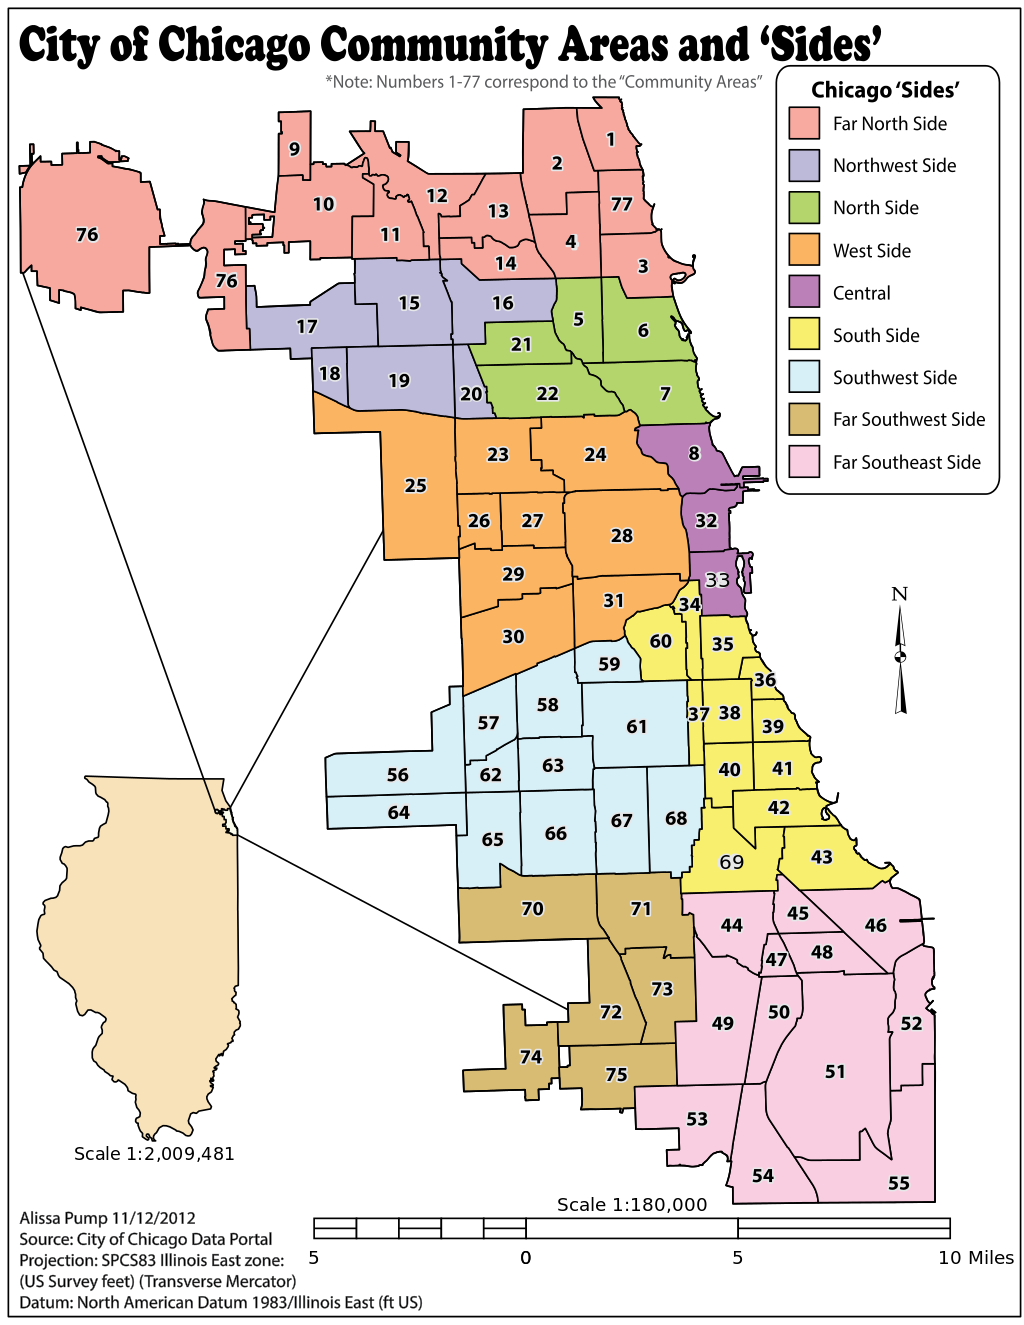

In [64]:
city = 'Chicago'
response = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/Map_of_the_Community_Areas_and_%27Sides%27_of_the_City_of_Chicago.svg/1024px-Map_of_the_Community_Areas_and_%27Sides%27_of_the_City_of_Chicago.svg.png")
img = Image.open(BytesIO(response.content))
img

In [65]:
side = [[8,32,33],[5,6,7,21,22],[1,2,3,4,9,10,11,12,13,14,76,77],[15,16,17,18,19,20],[23,24,25,26,27,28,29,30,31],[34,35,36,37,38,39,40,41,42,43,60,69]
,[56,57,58,59,61,62,63,64,65,66,67,68]
,[44,45,46,47,48,49,50,51,52,53,54,55]
,[70,71,72,73,74,75]]
ZoneDict = {}
for i,j in enumerate(side):
    for no in j:
        ZoneDict['zone'+str(no)] = str(i)

In [66]:
len(outliers)

638

In [67]:
len(data)

22968

In [68]:
matrix.shape

(638, 36)

In [69]:
f = open(RecordWritingPath+'F1ScoreSpatial.txt', 'a+')
# f.write('Spatial Aggregation Approach\n')
city = "Chicago"
f.write(city+'\n')
data = pd.read_csv(TransportationDataPath+city+'EdgeDatewiseAggregated.csv')
data['startZone'] = data['start_id'].apply(lambda x: ZoneDict[x])
data['endZone'] = data['end_id'].apply(lambda x: ZoneDict[x])
data = data.groupby(['startZone','endZone','date']).sum().reset_index()
data.columns = ['start_id', 'end_id', 'date', 'amount']

lis_event,df_finalEvents = getEvents(EventDataPath,city)

dataTs = getTimeSeries(data)
matrix = dataTs.values
matrix = np.log(matrix+1)
date = dataTs.index.to_frame().rename(columns={'date':'Date'})
for thres in range(1,10, 1):
    th = thres/10
    print("Threshhold: ",th)
    outliers = anomalyDetection(matrix,pval = th)
    EventsDF = df_finalEvents['Date'].drop_duplicates().to_frame()
    EventsDF['Anomaly'] = True
    date['Date'] = date['Date'].astype('str')
    EventsDF['Date'] = EventsDF['Date'].astype('str')
    df = EventsDF.merge(date,on='Date',how='right')
    df['outlier'] = outliers
    Precision = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(df[df['outlier']==True])
    Recall = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(EventsDF)
    if Precision+Recall > 0:
        F1 = (2*Precision*Recall)/(Precision+Recall)
    else:
        F1 = 0
    result[th] = F1
bestTh = max(result.items(), key=operator.itemgetter(1))[0]
f.write('overall F1: '+str(result[bestTh])+', Threshold: '+str(bestTh)+'\n')
f.write('event,single_type_recall,single_type_FPR\n')
EventType = list(df_finalEvents['Type'].unique())
outliers = anomalyDetection(matrix,pval = bestTh)
for event in EventType:
    print(event)
    SingleEventDF = df_finalEvents[df_finalEvents['Type'] == event]
    SingleEventDF = SingleEventDF.drop_duplicates()
    date['Date'] = date['Date'].astype('str')
    SingleEventDF['Date'] = SingleEventDF['Date'].astype('str')
    SingleDF = date.merge(SingleEventDF, on='Date', how='left')
#     SingleDF = SingleEventDF.merge(date,on='Date',how='left')
    SingleDF['outliers'] = outliers
#     SinglePrecision = len(SingleDF[(SingleDF['outlier']==True)&(SingleDF['Type'].notnull)])/len(SingleDF[SingleDF['outlier']==True])
    SingleRecall = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].notnull())])/len(SingleEventDF)
    SingleFPR = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].isna())])/len(SingleDF[SingleDF['Type'].isna()])
    print(SingleRecall, SingleFPR)
    f.write(event+','+str(SingleRecall)+','+str(SingleFPR)+'\n')
f.close()

getTimeSeries
Threshhold:  0.1
anomalyDetection
Threshhold:  0.2
anomalyDetection
Threshhold:  0.3
anomalyDetection
Threshhold:  0.4
anomalyDetection
Threshhold:  0.5
anomalyDetection
Threshhold:  0.6
anomalyDetection
Threshhold:  0.7
anomalyDetection
Threshhold:  0.8
anomalyDetection
Threshhold:  0.9
anomalyDetection
anomalyDetection
National Holiday
0.0 0.09986320109439124
Culture Event
0.0 0.09986320109439124
Extreme Weather
0.0 0.09986320109439124


# DC

In [70]:
city = 'DC'
ward = gpd.read_file(SpatialDataPath+'Ward_from_1990/Ward_from_1990.shp')
ward = ward[['NAME','geometry']]
neigh = gpd.read_file(SpatialDataPath+'Neighborhood_Clusters/Neighborhood_Clusters.shp')
neigh = neigh[['NAME','geometry']]
data = pd.read_csv(TransportationDataPath+city+'EdgeDatewiseAggregated.csv')
ward_neighbor = gpd.sjoin(ward,neigh, how='inner', op='intersects')

In [93]:
neighbor = list(ward_neighbor['NAME_right'])
wardName = list(ward_neighbor['NAME_left'])
ZoneDict = {}
for i in range(len(neighbor)):
    ZoneDict[neighbor[i]] = wardName[i]

In [72]:
f = open(RecordWritingPath+'F1ScoreSpatial.txt', 'a+')
# f.write('Spatial Aggregation Approach\n')
city = "DC"
f.write(city+'\n')
data = pd.read_csv(TransportationDataPath+city+'EdgeDatewiseAggregated.csv')
data['startZone'] = data['start_id'].apply(lambda x: ZoneDict[x])
data['endZone'] = data['end_id'].apply(lambda x: ZoneDict[x])
data = data.groupby(['startZone','endZone','date']).sum().reset_index()
data.columns = ['start_id', 'end_id', 'date', 'amount']

lis_event,df_finalEvents = getEvents(EventDataPath,city)

dataTs = getTimeSeries(data)
matrix = dataTs.values
matrix = np.log(matrix+1)
date = dataTs.index.to_frame().rename(columns={'date':'Date'})
for thres in range(1,10, 1):
    th = thres/10
    print("Threshhold: ",th)
    outliers = anomalyDetection(matrix,pval = th)
    EventsDF = df_finalEvents['Date'].drop_duplicates().to_frame()
    EventsDF['Anomaly'] = True
    date['Date'] = date['Date'].astype('str')
    EventsDF['Date'] = EventsDF['Date'].astype('str')
    df = EventsDF.merge(date,on='Date',how='right')
    df['outlier'] = outliers
    Precision = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(df[df['outlier']==True])
    Recall = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(EventsDF)
    if Precision+Recall > 0:
        F1 = (2*Precision*Recall)/(Precision+Recall)
    else:
        F1 = 0
    result[th] = F1
bestTh = max(result.items(), key=operator.itemgetter(1))[0]
f.write('overall F1: '+str(result[bestTh])+', Threshold: '+str(bestTh)+'\n')
f.write('event,single_type_recall,single_type_FPR\n')
EventType = list(df_finalEvents['Type'].unique())
outliers = anomalyDetection(matrix,pval = bestTh)
for event in EventType:
    print(event)
    SingleEventDF = df_finalEvents[df_finalEvents['Type'] == event]
    SingleEventDF = SingleEventDF.drop_duplicates()
    date['Date'] = date['Date'].astype('str')
    SingleEventDF['Date'] = SingleEventDF['Date'].astype('str')
    SingleDF = date.merge(SingleEventDF, on='Date', how='left')
#     SingleDF = SingleEventDF.merge(date,on='Date',how='left')
    SingleDF['outliers'] = outliers
#     SinglePrecision = len(SingleDF[(SingleDF['outlier']==True)&(SingleDF['Type'].notnull)])/len(SingleDF[SingleDF['outlier']==True])
    SingleRecall = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].notnull())])/len(SingleEventDF)
    SingleFPR = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].isna())])/len(SingleDF[SingleDF['Type'].isna()])
    print(SingleRecall, SingleFPR)
    f.write(event+','+str(SingleRecall)+','+str(SingleFPR)+'\n')
f.close()

getTimeSeries
Threshhold:  0.1
anomalyDetection
Threshhold:  0.2
anomalyDetection
Threshhold:  0.3
anomalyDetection
Threshhold:  0.4
anomalyDetection
Threshhold:  0.5
anomalyDetection
Threshhold:  0.6
anomalyDetection
Threshhold:  0.7
anomalyDetection
Threshhold:  0.8
anomalyDetection
Threshhold:  0.9
anomalyDetection
anomalyDetection
National Holiday
0.34146341463414637 0.7002840909090909
Protest
0.48 0.6981664315937941
Extreme Weather
0.7073170731707317 0.6988304093567251
Culture Event
0.75 0.6978723404255319


# New York City

In [99]:
city = "NewYork"
NewYorkTaxiZone = gpd.read_file(SpatialDataPath+"NYC Taxi Zones.geojson")
TaxiZone = list(NewYorkTaxiZone['objectid'])
borough = list(NewYorkTaxiZone['borough'])
# ZoneDict = {}
for i in range(len(TaxiZone)):
    ZoneDict[TaxiZone[i]] = borough[i]

In [100]:
f = open(RecordWritingPath+'F1ScoreSpatial.txt', 'a+')
# f.write('Spatial Aggregation Approach\n')
city = "NewYork"
f.write(city+'\n')
data = pd.read_csv(TransportationDataPath+city+'EdgeDatewiseAggregated.csv')
data['start_id'] = data['start_id'].astype('str')
data['end_id'] = data['end_id'].astype('str')
data['startZone'] = data['start_id'].apply(lambda x: ZoneDict[str(x)])
data['endZone'] = data['end_id'].apply(lambda x: ZoneDict[str(x)])
data = data.groupby(['startZone','endZone','date']).sum().reset_index()
data.columns = ['start_id', 'end_id', 'date', 'amount']

lis_event,df_finalEvents = getEvents(EventDataPath,city)

dataTs = getTimeSeries(data)
matrix = dataTs.values
matrix = np.log(matrix+1)
date = dataTs.index.to_frame().rename(columns={'date':'Date'})
for thres in range(1,10, 1):
    th = thres/10
    print("Threshhold: ",th)
    outliers = anomalyDetection(matrix,pval = th)
    EventsDF = df_finalEvents['Date'].drop_duplicates().to_frame()
    EventsDF['Anomaly'] = True
    date['Date'] = date['Date'].astype('str')
    EventsDF['Date'] = EventsDF['Date'].astype('str')
    df = EventsDF.merge(date,on='Date',how='right')
    df['outlier'] = outliers
    Precision = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(df[df['outlier']==True])
    Recall = len(df[(df['outlier']==True)&(df['Anomaly']==True)])/len(EventsDF)
    if Precision+Recall > 0:
        F1 = (2*Precision*Recall)/(Precision+Recall)
    else:
        F1 = 0
    result[th] = F1
bestTh = max(result.items(), key=operator.itemgetter(1))[0]
f.write('overall F1: '+str(result[bestTh])+', Threshold: '+str(bestTh)+'\n')
f.write('event,single_type_recall,single_type_FPR\n')
EventType = list(df_finalEvents['Type'].unique())
outliers = anomalyDetection(matrix,pval = bestTh)
for event in EventType:
    print(event)
    SingleEventDF = df_finalEvents[df_finalEvents['Type'] == event]
    SingleEventDF = SingleEventDF.drop_duplicates()
    date['Date'] = date['Date'].astype('str')
    SingleEventDF['Date'] = SingleEventDF['Date'].astype('str')
    SingleDF = date.merge(SingleEventDF, on='Date', how='left')
#     SingleDF = SingleEventDF.merge(date,on='Date',how='left')
    SingleDF['outliers'] = outliers
#     SinglePrecision = len(SingleDF[(SingleDF['outlier']==True)&(SingleDF['Type'].notnull)])/len(SingleDF[SingleDF['outlier']==True])
    SingleRecall = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].notnull())])/len(SingleEventDF)
    SingleFPR = len(SingleDF[(SingleDF['outliers']==True)&(SingleDF['Type'].isna())])/len(SingleDF[SingleDF['Type'].isna()])
    print(SingleRecall, SingleFPR)
    f.write(event+','+str(SingleRecall)+','+str(SingleFPR)+'\n')
f.close()

getTimeSeries
Threshhold:  0.1
anomalyDetection
Threshhold:  0.2
anomalyDetection
Threshhold:  0.3
anomalyDetection
Threshhold:  0.4
anomalyDetection
Threshhold:  0.5
anomalyDetection
Threshhold:  0.6
anomalyDetection
Threshhold:  0.7
anomalyDetection
Threshhold:  0.8
anomalyDetection
Threshhold:  0.9
anomalyDetection
anomalyDetection
National Holiday
0.0 0.1
Culture Event
0.0 0.1
Extreme Weather
0.0 0.1
